<a href="https://colab.research.google.com/github/microsoft/autogen/blob/main/notebook/agenteval_cq_math.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Demonstrating the `AgentEval` framework using the task of solving GAIA bechmark

This notebook aims to demonstrate how to `AgentEval` implemented through [AutoGen](https://github.com/microsoft/autogen) works, where we use a math problem-solving task as an example. 
`AgentEval` consists of two key components:

- `CriticAgent`: This is an LLM-based agent that generates a list criteria $(c_1, \dots, c_n)$ to help to evaluate a utility given task.

- `QuantifierAgent`: This agent quantifies the performance of any sample task based on the criteria designed by the `CriticAgent` in the following way: $(c_1=a_1, \dots, c_n=a_n)$

![AgentEval](../website/blog/2023-11-11-AgentEval/img/agenteval-CQ.png)

For more detailed explanations, please refer to the accompanying [blog post](https://https://microsoft.github.io/autogen/blog/2023/11/11/AgentEval)

## Requirements

AutoGen requires `Python>=3.8`. To run this notebook example, please install pyautogen, Docker, and OpenAI:


In [ ]:
%pip install "pyautogen>=0.2.3"
%pip install scipy
%pip install matplotlib

## Set your API Endpoint

* The [`config_list_openai_aoai`](https://microsoft.github.io/autogen/docs/reference/oai/openai_utils#config_list_openai_aoai) function tries to create a list of configurations using Azure OpenAI endpoints and OpenAI endpoints. It assumes the api keys and api bases are stored in the corresponding environment variables or local txt files:
  - OpenAI API key: os.environ["OPENAI_API_KEY"] or `openai_api_key_file="key_openai.txt"`.
  - Azure OpenAI API key: os.environ["AZURE_OPENAI_API_KEY"] or `aoai_api_key_file="key_aoai.txt"`. Multiple keys can be stored, one per line.
  - Azure OpenAI API base: os.environ["AZURE_OPENAI_API_BASE"] or `aoai_api_base_file="base_aoai.txt"`. Multiple bases can be stored, one per line.
* The [`config_list_from_json`](https://microsoft.github.io/autogen/docs/reference/oai/openai_utils#config_list_from_json) function loads a list of configurations from an environment variable or a json file. It first looks for an environment variable with a specified name. The value of the environment variable needs to be a valid json string. If that variable is not found, it looks for a json file with the same name. It filters the configs by filter_dict.

You can set the value of config_list in any way you prefer. Please refer to this [notebook](https://github.com/microsoft/autogen/blob/main/notebook/oai_openai_utils.ipynb) for full code examples of the different methods.


In [45]:
import autogen

print(autogen.__version__)

#config_list = json.loads(secrect-string)

config_list = autogen.config_list_from_json(
    env_or_file="../OAI_CONFIG_LIST",
    file_location=".",
    filter_dict={
        "model": ["gpt-4"],
    },
)

#print(config_list[0]["base_url"])


0.2.9


In [46]:
import json
import os

solution_based_c = []
number_json_error = 0

# Iterate through files in the directory
for file in os.listdir('../logs/solution-based/'):
    with open('../logs/solution-based/' + file, 'r') as f:
        # Read the file content
        file_content = f.read()
        
        # Replace single quotes with double quotes
        fixed_content = file_content.replace("'", '"')
        
        # Load JSON object from fixed content
        try:
            json_object = json.loads(fixed_content)
        except json.JSONDecodeError as e:
            number_json_error = number_json_error + 1
            print(f"Error decoding JSON in file {file}: {e}")
            continue
        
        # Extract keys and convert them to lowercase
        for key in json_object.keys():
            print("Criteria " + key.lower().replace('_', ' '))
            solution_based_c.append(key.lower().replace('_', ' '))

# Print the keys
#print(number_json_error)  
print(f"Number of keys {len(solution_based_c)}")                      
print(solution_based_c)


Criteria completeness
Criteria correctness
Criteria efficiency
Criteria originality
Criteria accuracy
Criteria response to correction
Criteria creativity
Criteria resourcefulness
Criteria novelty
Criteria collaboration
Criteria adaptability
Criteria reliability
Criteria understandability
Criteria execution steps
Criteria problem complexity
Criteria uniqueness of solution
Criteria time efficiency
Criteria data integrity
Criteria resource identification
Criteria question understanding
Criteria depth of analysis
Criteria communication
Criteria diversity and complexity coverage
Criteria internet independence
Criteria relevance
Criteria innovation
Criteria robustness
Criteria linguistic competence
Criteria agent cooperation
Criteria scalability
Criteria informativeness
Criteria reasoning traceability
Criteria data contamination prevention
Error decoding JSON in file gaia-30-0383a3ee-47a7-41a4-b493-519bdefe0488.json: Expecting ',' delimiter: line 32 column 36 (char 1475)
Error decoding JSON 

In [ ]:
#%pip install wordcloud
%pip install sentence-transformers

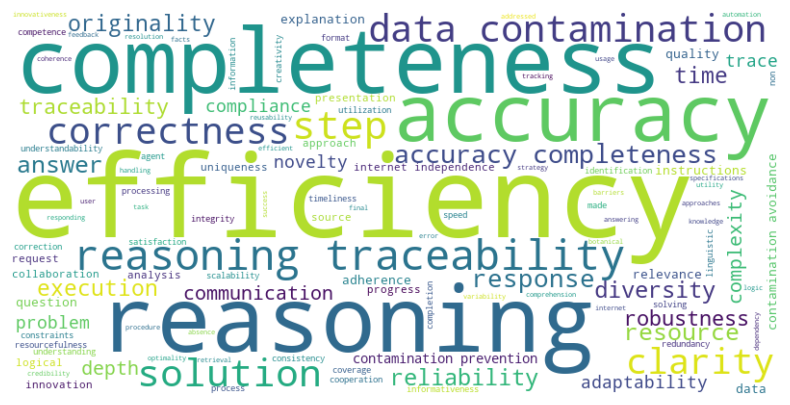

In [48]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Your list of terms

# Convert the list of terms into a single string
text = " ".join(solution_based_c)

# Create a WordCloud object
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(text)

# Display the word cloud using matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

Find synonyms in the list

In [49]:
from sentence_transformers import SentenceTransformer
import numpy as np

def find_synonymous_in_list(word_list, threshold=0.75):
    model = SentenceTransformer('paraphrase-MiniLM-L6-v2')  # Load a pre-trained SentenceTransformer model
    embeddings = model.encode(word_list, convert_to_tensor=True)  # Compute embeddings for the word list

    processed_words = set()
    used_in_synonyms = set()
    synonymous_dict = {}

    for i, word in enumerate(word_list):
        if word not in processed_words and word not in used_in_synonyms:
            synonymous_list = []
            for j, other_word in enumerate(word_list):
                if i != j:
                    cosine_sim = np.dot(embeddings[i], embeddings[j]) / (np.linalg.norm(embeddings[i]) * np.linalg.norm(embeddings[j]))
                    if cosine_sim > threshold:
                        synonymous_list.append(other_word)
                        used_in_synonyms.add(other_word)
            if synonymous_list or word not in synonymous_dict:  # Check if synonymous_list is not empty or word is not already added
                synonymous_list = list(set(synonymous_list))  # Remove duplicates from the list
                synonymous_list.sort()  # Sort the list to make the output consistent
                synonymous_dict[word] = synonymous_list
            processed_words.add(word)
    
    return synonymous_dict

# Example usage:
#word_list = ["happy", "happy", "joyful", "sad", "unhappy", "merry"]
#synonymous_dict = find_synonymous_in_list(word_list)
synonymous_dict = find_synonymous_in_list(solution_based_c)
print(f"Number of key in synonimous dict {len(synonymous_dict)}")
print(synonymous_dict)


Number of key in synonimous dict 80
{'completeness': ['answer completeness', 'completeness', 'reasoning completeness'], 'correctness': ['answer correctness', 'correctness', 'reasoning correctness'], 'efficiency': ['efficiency', 'execution efficiency', 'solution efficiency', 'steps efficiency'], 'originality': ['originality'], 'accuracy': ['accuracy', 'accuracy of answer', 'accuracy of answers', 'accuracy of facts', 'accuracy of information', 'accuracy of solution', 'data processing accuracy', 'reasoning accuracy', 'solution accuracy'], 'response to correction': ['response to correction'], 'creativity': ['creativity'], 'resourcefulness': ['resourcefulness'], 'novelty': ['novelty', 'solution novelty'], 'collaboration': ['collaboration'], 'adaptability': ['adaptability'], 'reliability': ['data reliability', 'reliability', 'reliability of solution', 'solution reliability', 'source reliability'], 'understandability': ['understandability'], 'execution steps': ['execution', 'execution steps',

In [50]:
for word in synonymous_dict.keys():
    print(word) 

completeness
correctness
efficiency
originality
accuracy
response to correction
creativity
resourcefulness
novelty
collaboration
adaptability
reliability
understandability
execution steps
problem complexity
uniqueness of solution
time efficiency
data integrity
resource identification
question understanding
depth of analysis
communication
diversity and complexity coverage
internet independence
relevance
innovation
robustness
linguistic competence
agent cooperation
scalability
informativeness
reasoning traceability
data contamination prevention
response time
correctness of analysis
completeness of reasoning
logical consistency
explanation clarity
efficiency of steps
response timeliness
robustness to diversity
responding to barriers
compliance with specifications
completeness of steps
resource efficiency
adaptability to task diversity
originality of information
adherence to request
completeness of question answering
resource credibility
answer presentation
request satisfaction
progress ma

In [ ]:
import os
import json

specified_keys_lower = synonymous_dict.keys()
path_to_json = '../logs/solution-based/'

def filter_json_files(path_to_files, specified_keys):
    combined_json = {}
    for file_name in os.listdir(path_to_files):
        file_path = os.path.join(path_to_files, file_name)
        if os.path.isfile(file_path):  # Check if it's a file
            try:
                with open(file_path, 'r') as f:
                    # Read the file content
                    file_content = f.read().lower()
                    # Replace single quotes with double quotes
                    fixed_content = file_content.replace("'", '"')
                    # Load JSON object from fixed content
                    data = json.loads(fixed_content)
                    for key, value in data.items():
                        if key.lower() in specified_keys:
                            combined_json[key] = value
            except json.JSONDecodeError as e:
                print(f"Error decoding JSON in file {file_name}: {e}")
                continue
    return combined_json        

combined_data = filter_json_files(path_to_json, specified_keys_lower)

def write_json_file(data, file_path):
    with open(file_path, 'w') as file:
        json.dump(data, file, indent=4)

write_json_file(combined_data, os.path.join(path_to_json, "final_criteria.json"))


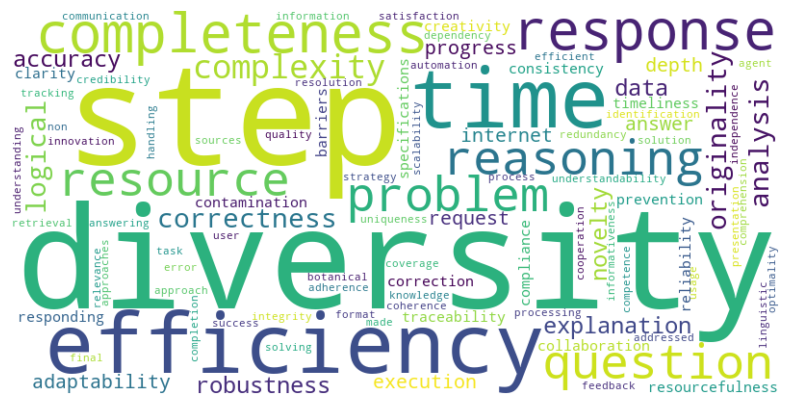

In [36]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Your list of terms

# Convert the list of terms into a single string
text = " ".join(synonymous_dict.keys())

# Create a WordCloud object
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(text)

# Display the word cloud using matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [40]:
criteria_file = f"{path_to_json}final_criteria.json"

quantifier = autogen.AssistantAgent(
    name = "quantifier",
    llm_config = {"config_list": config_list, "max_retries": 10},
    system_message = """You are a helpful assistant. You quantify the output of different tasks based on the given criteria.
    The criterion is given in a dictionary format where each key is a dintinct criteria.
    The value of each key is a dictionary as follows {"description": criteria description , "accepted_values": possible accepted inputs for this key}
    You are going to quantify each of the crieria for a given task based on the task decription.
    Return a dictionary where the keys are the criteria and the values are the assessed performance based on accepted values for each criteria.
    Return only the dictionary."""
)

quantifier_user = autogen.UserProxyAgent(
    name = "quantifier_user",
    max_consecutive_auto_reply = 0,  # terminate without auto-reply
    human_input_mode = "NEVER",
    code_execution_config={"use_docker": False},
)

dictionary_for_eval = open(criteria_file,"r").read()

In [ ]:



def read_gaia_logs(file_name, correctness):
    """
    Read the mathproblem logs line by line - extract specific fields.

    Args:
    - file_name (str): The single log file that wants to get evaluated.

    Returns:
    - list: A list of tuples, each containing the test case and correctness.
    """
    results = []

    with open(file_name, "r") as f:
        for line in f:
            #print("Line: "+ line)
            try:
                data = json.loads(line)
                task_id = data.get('task_id','')
                question = data.get('Question', '')
                reasoning_trace = json.dumps(data.get('reasoning_trace', ''))
                test_case = "Question is "+ question + " The agent reasoning is " + reasoning_trace
                results.append((task_id, test_case[:128000], correctness))
            except json.JSONDecodeError as e:
                print(f"Error decoding JSON: {e}")

    return results

def get_quantifier(success_file, failed_file, criteria_file):
    """
    Running quantifier agent on individual log.

    Args:
    - success_file (str): The log path for successful cases.
    - failed_file (str): The log path for failed cases.
    - criteria_file (str): The criteria JSON file path.
    
    Returns:
    - dict: A dictionary including the actual success of each problem as well as estimated performance by the agent eval.
      {"results": [{"actual_success": actual_label, "estimated_performance": quantified_results["content"]}, ...]}
    """
    dictionary_for_eval = open(criteria_file, "r").read()
    results = []

    # Append results for successful and failed cases
    results.extend(read_gaia_logs(success_file, "correct"))
    results.extend(read_gaia_logs(failed_file, "incorrect"))
  
    
    output_file_path = "../test/test_files/agenteval-in-out/gaia_evaluated_problems_Orchestrator.oai.json"
    output_file_path_line_by_line = "../logs/gaia_validation_level_1__Orchestrator.oai.jsonl"
 
    all_data = {}

    # Iterate through the loop where you have access to task_id, test_case, and actual_label
    for task_id, test_case, actual_label in results:
        quantifier_user.initiate_chat(quantifier, message=sys_msg + \
                                                "Evaluation dictionary: " + str(dictionary_for_eval) + \
                                                "Actual test case to evaluate: " + test_case)
        quantified_results = quantifier_user.last_message()

        # Construct the nested dictionary for each file
        nested_dict = {
            "task_id": task_id,
            "actual_success": actual_label,
            "estimated_performance": quantified_results["content"]
        }

        # Add the nested dictionary to the all_data dictionary
        all_data[task_id] = nested_dict

        # Write each line of the nested dictionary to the JSONL file
        with open(output_file_path_line_by_line, "a") as file:
            json.dump(nested_dict, file)
            file.write('\n')  # Add a newline after each JSON object


    # Write the entire dictionary to the JSON file
    with open(output_file_path, "w") as file:
        json.dump(all_data, file, indent=2)


get_quantifier("../test/test_files/agenteval-in-out/sample-gaia_1output_equal.jsonl", "../test/test_files/agenteval-in-out/sample-gaia_1output_not_equal.jsonl", criteria_file)  

